# Request data from USGS and save to CSV

In [ ]:
import requests
import pandas as pd

# Set the API endpoint URL
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

# Define the bounding box for the area of interest
min_latitude = 10
max_latitude = 60
min_longitude = 134 #117 is wide
max_longitude = 174 #165 more tight

# Create an empty list to hold the earthquake data
earthquakes = []

for year in range(1973, 2023):
    for month in range(1, 13):
        # Set the parameters for the API request
        starttime = f'{year}-{month:02d}-01'
        endtime = f'{year}-{month+1:02d}-01'
        if month == 12:
            endtime = f'{year+1}-01-01'
        params = {
            'format': 'geojson',
            'starttime': starttime,
            'endtime': endtime,
            'minmagnitude': '0',
            'maxmagnitude': '10',
            'minlatitude': min_latitude,
            'maxlatitude': max_latitude,
            'minlongitude': min_longitude,
            'maxlongitude': max_longitude,
            'mindepth': '0',
            'maxdepth': '1000',
        }

        # Send the API request and get the response
        response = requests.get(url, params=params)

        # Parse the JSON response
        data = response.json()

        # Extract the data for each earthquake and append it to the list
        for feature in data['features']:
            longitude = feature['geometry']['coordinates'][0]
            latitude = feature['geometry']['coordinates'][1]
            time = pd.to_datetime(feature['properties']['time'], unit='ms')
            magnitude = feature['properties']['mag']
            depth = feature['geometry']['coordinates'][2]
            focal_mechanism = feature['properties']['types'][0]
            earthquake = {'Longitude': longitude, 'Latitude': latitude, 'Time': time, 'Magnitude': magnitude, 'Depth': depth}
            earthquakes.append(earthquake)
# Create a DataFrame from the list of earthquake data
df = pd.DataFrame(earthquakes)

# Cut off magnitudes of 0
df = df[df.Magnitude > 0]

# save as csv
# df.to_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')

# Print the first few rows of the DataFrame
print(df.head())
print(df.shape, df.Magnitude.min())


## Transform CSV to 3D numpy array (where D3 are bins of magnitude) and save .npy

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Load earthquake data
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023.csv')

# Define area of interest
min_lon = 134
max_lon = 174
min_lat = 10
max_lat = 60

# Define time window size (1 week in this case)
window_size = timedelta(weeks=1)

# Calculate number of time windows
data['Time'] = pd.to_datetime(data.Time)
start_time = data['Time'].min()
end_time = data['Time'].max()
num_time_windows = (end_time - start_time) // window_size + 1

# Define spatial bin size (2 degrees in this case)
bin_size = 2

# Calculate number of spatial bins
num_lon_bins = int((max_lon - min_lon) / bin_size)
num_lat_bins = int((max_lat - min_lat) / bin_size)
num_bins = num_lon_bins * num_lat_bins

# Define magnitude bin size and number of bins
num_mag_bins = 10

# Create tensor with zeros
tensor = np.zeros((num_bins, num_time_windows, num_mag_bins), dtype=int)

# Iterate over time windows
for i in range(num_time_windows):
    # Get earthquake data within current time window
    mask = (data['Time'] >= start_time) & (data['Time'] < start_time + window_size)
    window_data = data.loc[mask]

    # Iterate over spatial bins
    for lon in range(min_lon, max_lon, bin_size):
        for lat in range(min_lat, max_lat, bin_size):
            # Get earthquake data within current spatial bin
            bin_data = window_data[(window_data['Longitude'] >= lon) & (window_data['Longitude'] < lon + bin_size) & 
                                   (window_data['Latitude'] >= lat) & (window_data['Latitude'] < lat + bin_size)]

            
            # Bin magnitudes between 0 and 10 and count number of earthquakes in each bin
            magnitudes = bin_data['Magnitude']
            counts, _ = np.histogram(magnitudes, bins=np.linspace(0, 10, num_mag_bins+1))

            # Store counts in tensor
            bin_idx = (lon - min_lon)//bin_size*num_lat_bins + (lat - min_lat)//bin_size
            tensor[bin_idx, i, :] = counts
    
    # Increment time window
    start_time += window_size


# Print tensor shape
np.save('data/Japan_10_60_134_174_1973_2023.npy',tensor)
print(tensor.shape)

## Convert CSV to 2D numpy array where rows are 2x2 degrees pixels and columns are bins of time of a day

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Load earthquake data
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023.csv')

# Define area of interest
min_lon = 134
max_lon = 174
min_lat = 10
max_lat = 60

# Define time window size (1 day in this case)
window_size = timedelta(days=1)

# Calculate number of time windows
data['Time'] = pd.to_datetime(data.Time)
start_time = data['Time'].min()
end_time = data['Time'].max()
num_time_windows = (end_time - start_time) // window_size + 1

# Define spatial bin size (2 degrees in this case)
bin_size = 2

# Calculate number of spatial bins
num_lon_bins = int((max_lon - min_lon) / bin_size)
num_lat_bins = int((max_lat - min_lat) / bin_size)
num_bins = num_lon_bins * num_lat_bins

# Create tensor with zeros
tensor = np.zeros((num_bins, num_time_windows))

# Iterate over time windows
for i in range(num_time_windows):
    # Get earthquake data within current time window
    mask = (data['Time'] >= start_time) & (data['Time'] < start_time + window_size)
    window_data = data.loc[mask]

    # Iterate over spatial bins
    for lon in range(min_lon, max_lon, bin_size):
        for lat in range(min_lat, max_lat, bin_size):
            # Get earthquake data within current spatial bin
            bin_data = window_data[(window_data['Longitude'] >= lon) & (window_data['Longitude'] < lon + bin_size) & 
                                   (window_data['Latitude'] >= lat) & (window_data['Latitude'] < lat + bin_size)]

            # Check if there are any earthquakes in the current bin
            if not bin_data.empty:
                # Find the maximum magnitude in the current bin
                max_mag = bin_data['Magnitude'].max()

                # Store maximum magnitude in tensor
                bin_idx = (lon - min_lon)//bin_size*num_lat_bins + (lat - min_lat)//bin_size
                tensor[bin_idx, i] = max_mag
    
    # Increment time window
    start_time += window_size

print(tensor.shape)

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Load earthquake data
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023.csv')

# Define area of interest
min_lon = 134
max_lon = 174
min_lat = 10
max_lat = 60

# Define time window size (1 day in this case)
window_size = timedelta(days=1)

# Calculate number of time windows
data['Time'] = pd.to_datetime(data.Time)
start_time = data['Time'].min()
end_time = data['Time'].max()
num_time_windows = (end_time - start_time) // window_size + 1

# Define spatial bin size (2 degrees in this case)
bin_size = 5

# Calculate number of spatial bins
num_lon_bins = int((max_lon - min_lon) / bin_size)
num_lat_bins = int((max_lat - min_lat) / bin_size)
num_bins = num_lon_bins * num_lat_bins

# Create tensor with zeros
tensor = np.zeros((num_bins, num_time_windows))

# Create DataFrame to store bin information
bins_df = pd.DataFrame(columns=['Longitude', 'Latitude'])

# Iterate over spatial bins
for lon in range(min_lon, max_lon, bin_size):
    for lat in range(min_lat, max_lat, bin_size):
        # Add bin information to DataFrame
        bins_df = pd.concat([bins_df, pd.DataFrame({'Longitude': lon, 'Latitude': lat}, index=[0])], ignore_index=True)


# Iterate over time windows
for i in range(num_time_windows):
    # Get earthquake data within current time window
    mask = (data['Time'] >= start_time) & (data['Time'] < start_time + window_size)
    window_data = data.loc[mask]

    # Iterate over spatial bins
    for j in range(num_bins):
        lon = bins_df.loc[j, 'Longitude']
        lat = bins_df.loc[j, 'Latitude']
        
        # Get earthquake data within current spatial bin
        bin_data = window_data[(window_data['Longitude'] >= lon) & (window_data['Longitude'] < lon + bin_size) & 
                               (window_data['Latitude'] >= lat) & (window_data['Latitude'] < lat + bin_size)]

        # Check if there are any earthquakes in the current bin
        if not bin_data.empty:
            # Find the maximum magnitude in the current bin
            max_mag = bin_data['Magnitude'].max()

            # Store maximum magnitude in tensor
            bin_idx = j
            tensor[bin_idx, i] = max_mag

    # Increment time window
    start_time += window_size

# Add longitude and latitude columns to DataFrame
bins_df['Longitude'] += bin_size/2
bins_df['Latitude'] += bin_size/2

print(bins_df.head())
print(tensor.shape)
df = pd.concat((pd.DataFrame(tensor), bins_df), axis=1)
# df.to_csv('data/Japan_10_60_134_174_D_5X5_1973_2023.csv', index=False)


## Plot earthquake magnitudes on map

In [ ]:
import cartopy.crs as crs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker

df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv').sort_values('Magnitude')
# Create a map using Cartopy to display earthquake data with magnitudes, longitude, and latitude
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=crs.Mercator())
ax.add_feature(cartopy.feature.LAND, facecolor=[.8,.8,.8])
ax.add_feature(cartopy.feature.OCEAN, facecolor=[.95,.95,.95])
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)

# Add gridlines
lon = np.linspace(-180,180,181)
lat = np.linspace(-90,90,91)

gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(lon)
gl.ylocator = mticker.FixedLocator(lat)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = True
#gl.xlabel_style = {'rotation': 45}

# Add coastlines
ax.coastlines(color='black', linewidth=0.5)

# Plot the earthquake data as scatter points
sc = ax.scatter(df['Longitude'], df['Latitude'], c=df['Magnitude'], cmap="inferno", s=np.exp(df['Magnitude'])/100, transform=crs.PlateCarree())

# Set the colorbar and its label
cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('Magnitude')

# Set the plot title and axis labels
ax.set_title('Earthquakes between 1973 and 2023')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Set the bounds of the map to the minimum and maximum longitude and latitude values
# Determine the minimum and maximum longitude and latitude values
min_lon, max_lon = df['Longitude'].min(), df['Longitude'].max()
min_lat, max_lat = df['Latitude'].min(), df['Latitude'].max()
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=crs.PlateCarree())


# Show the plot
plt.show()

## Plot earthquake magnitudes over time

In [ ]:
import matplotlib.pyplot as plt

df['Time'] = pd.to_datetime(df.Time)

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df.Time, df.Magnitude, s=.1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

## Plot earthquake depth over time

In [ ]:
import matplotlib.pyplot as plt

df['Time'] = pd.to_datetime(df.Time)

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df.Time, df.Depth, s=.1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

## Plot 2D histogram of amount of earthquakes

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
df['Time'] = pd.to_datetime(df.Time)
df = df.set_index('Time')
df = df.sort_index()

sns.set(rc={'figure.figsize':(4.8,6)})
g = sns.histplot(
    df, x="Longitude", y="Latitude",
    bins=(20,25), cbar=True)

g.set_xticks(ticks=np.linspace(134, 174, 21), labels=np.linspace(134, 174, 21).astype(int), rotation = 90)

g.set_yticks(ticks=np.linspace(10, 60, 26), labels=np.linspace(10, 60, 26).astype(int))
sns.set(rc={'figure.figsize':(8,8)})


## Plot the most active 2x2 area

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
df['Time'] = pd.to_datetime(df.Time)
pixel = df[(df.Longitude > 140) & (df.Longitude < 142) & (df.Latitude > 36) & (df.Latitude < 38)]
fig, ax = plt.subplots(figsize=(6,4))
plt.scatter(pixel.Time, pixel.Magnitude, s=.1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

## Plot distribution of earthquakes

In [ ]:
import seaborn as sns
sns.jointplot(
    data=df, x="Magnitude", y="Depth", s=1, marginal_ticks=True, marginal_kws=dict(bins=74)
)

## Plot correlation between pixels

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/Japan_10_60_134_174_D_1973_2023.csv').iloc[:,:-2]
df = df[(df > 0).any(axis=1)]
df = df.rolling(14,axis=1, center=True, min_periods=0).mean()
plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(df),0, cmap='seismic',vmin=-1, vmax=1)
plt.xlabel("2x2 grid pixel")
plt.ylabel("2x2 grid pixel")
plt.colorbar()
plt.show()

# Implement ARIMA on 10x10 pixel

In [ ]:
# import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# load earthquake data for a specific area
data = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
data['Time'] = pd.to_datetime(data.Time)
data = data[(data.Longitude > 140) & (data.Longitude < 145) & (data.Latitude > 35) & (data.Latitude < 40)]
data.set_index('Time', inplace=True)
data = data['Magnitude'].resample('M').max()  # resample by day and get the maximum magnitude of the day
data = data.fillna(0)


"""
# fit an ARIMA model to get the summary
model = ARIMA(data, order=(3, 0, 3))  # (p, d, q) order
model_fit = model.fit()
print(model_fit.summary())
"""

train_size = 12 * 2
total_splits = len(data)-train_size
test_size = 1

cv = TimeSeriesSplit(n_splits=total_splits, max_train_size=train_size ,test_size=test_size)

mae_total = 0
TP = 0
FP = 0
TN = 0
FN = 0

y_true = []
y_pred = []

mag = 6

for train_index, test_index in cv.split(data):
    #print("TRAIN:", train_index, "TEST:", test_index)

    # fit an ARIMA model
    model = ARIMA(data[train_index], order=(1, 1, 0))  # (p, d, q) order
    model_fit = model.fit()

    # forecast next week's magnitudes
    forecast = model_fit.forecast(steps=test_size)
    # print('true:', data[test_index][0], 'prediction:', round(forecast[0],1))

    # evaluate model performance
    mae = mean_absolute_error(data[test_index], forecast)
    mae_total += mae
    #print('inermediate MSE:', mse)

    if data[test_index][0] >= mag:
        y_true.append(1)
        if forecast[0] >= mag:
            y_pred.append(1)
            TP += 1
        if forecast[0] < mag:
            FN += 1
            y_pred.append(0)
    if data[test_index][0] < mag:
        y_true.append(0)
        if forecast[0] >= mag:
            y_pred.append(1)
            FP += 1
        if forecast[0] < mag:
            y_pred.append(0)
            TN += 1

acc = (TP+TN) / (TP+TN+FP+FN)
precision = TP / (TP+FP)
recall = TP / (TP+FN)
specificity = TN / (TN+FP)

print('accuracy:', acc)
print('precision:', precision)
print('recall:', recall)
print('specificity:', specificity)
print('Mean Absolute Error:', mae_total/total_splits)

cm = confusion_matrix(y_true, y_pred)
class_names = ['M<6','M>=6']

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## visualise ACF to define MA

In [ ]:
acf_val = acf(data)
plt.bar(range(0,len(acf_val)),acf_val)

## visualize PACF to define AR

In [ ]:
pacf_val = pacf(data)
plt.bar(range(0,len(pacf_val)),pacf_val)

## Visualise distribution of magnitudes

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('data/Japan_10_60_134_174_D_5X5_1973_2023.csv').iloc[:,:-2]
print(np.unique(df))
print("mean:", np.mean(np.array(df)[df > 0]))

X = 6
print("percentage of values bigger than X:", (np.array(df) >= X).sum() / len(np.array(df).flatten()))
sns.histplot(np.array(df).flatten(), bins=90, log_scale=(False,True))
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of earthquake magnitudes')
plt.show()


# LSTM

### Create 2d array

In [ ]:
import numpy as np
import pandas as pd

# Choose frequency and binsize
freq = 'M'
binsize = 5

# Load earthquake data into a pandas DataFrame
df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
df['Time'] = pd.to_datetime(df.Time)
df = df.set_index('Time')
df = df.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(134, 175, binsize))
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(10, 61, binsize))

# Group the data by longitude bin, latitude bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', pd.Grouper(freq=freq, level='Time')])['Magnitude'].max()

# Convert the resulting data to a DataFrame, filling missing values with 0
grouped_df = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor with shape (1, time, rows, cols, channels)
time = len(grouped_df.columns)
rows = len(grouped_df.index.levels[0])
cols = len(grouped_df.index.levels[1])
dataset = np.zeros((1, time, rows, cols, 1))

for t in range(time):
    dataset[0, t, :, :, 0] = grouped_df.iloc[:, t].values.reshape(rows, cols)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
dataset = np.transpose(dataset, axes=(0, 1, 3, 2, 4))
dataset = np.flip(dataset, axis=2)

dataset = dataset.reshape((dataset.shape[1], -1))
dataset = dataset[:, dataset.any(axis=0)]
# Print the shape of the resulting tensor
print(dataset.shape)

### Create train and test sets

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator

# define magnitude cutoff
mag = 4.5
mag_select = (dataset >= mag)

# scale data
scaler = StandardScaler()
dataset = scaler.fit_transform(dataset)

# split data in train en test set
train, test = train_test_split(dataset, test_size=.3, shuffle=False, random_state=43)
mag_train, mag_test = train_test_split(mag_select, test_size=.3, shuffle=False, random_state=43)

# define generator
n_features = dataset.shape[1]
n_input = 10
steps_epoch = 32
train_generator = TimeseriesGenerator(train, mag_train.astype(int), length=n_input, batch_size=(len(train) - n_input) // steps_epoch, shuffle=False)
test_generator = TimeseriesGenerator(test, mag_test.astype(int), length=n_input, batch_size=(len(test) - n_input) // steps_epoch, shuffle=False)

In [ ]:
# multivariate one step problem with lstm
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Flatten, Input, TimeDistributed, Dropout, RepeatVector, BatchNormalization
from keras.layers import LSTM
from tensorflow.keras.utils import plot_model
import pandas as pd
import numpy as np
import keras
from keras.callbacks import EarlyStopping
from keras import backend as K

keras.backend.clear_session()

#########################
"""
input= Input(shape=(n_input, n_features))

lstm1 = LSTM(12,return_state=True)
LSTM_output, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

repeat=RepeatVector(1)
LSTM_output = repeat(LSTM_output)

lstm2 = LSTM(12,return_sequences=True)
all_state_h = lstm2(LSTM_output,initial_state=states)


dense = TimeDistributed(Dense(n_features, activation='sigmoid'))
output = dense(all_state_h)
model_LSTM_return_state = Model(input,output,name='model_LSTM_return_state')

model_LSTM_return_state.compile(loss='binary_crossentropy', optimizer='adam')

########################
#
encoder_inputs = Input(shape=(n_input, n_features))
encoder_outputs1 = LSTM(12,return_sequences = True, return_state=True, activation='tanh')(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_outputs2 = LSTM(12, return_state=True, activation='tanh')(encoder_outputs1[0])

encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = RepeatVector(1)(encoder_outputs2[0])
#
decoder_l1 = LSTM(12, return_sequences=True, activation='tanh')(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = LSTM(12, return_sequences=True, activation='tanh')(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = TimeDistributed(Dense(n_features, activation='sigmoid'))(decoder_l2)
#
model = Model(encoder_inputs,decoder_outputs2)
#

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy')
print(model.summary())
"""

# define model
model = Sequential()
model.add(BatchNormalization())
model.add(LSTM(12, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)))
model.add(BatchNormalization())
model.add(LSTM(12, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)))
model.add(BatchNormalization())
model.add(LSTM(12, activation='tanh', input_shape=(n_input, n_features)))
model.add(BatchNormalization())
# model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(n_features, activation='sigmoid'))

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])



### fit model

In [ ]:
# early stopping
callback = EarlyStopping(monitor='val_loss', patience=5)
# fit model
history = model.fit(train_generator, validation_data=test_generator, steps_per_epoch=steps_epoch, epochs=1000, verbose=1, callbacks=[callback])

In [ ]:
y_pred = model.predict(test_generator)

y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(test)

### metrics

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5)
print('F1 score: %f' % f1)

class_names = ['M<6', 'M>=6']

print(classification_report(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5, target_names=class_names))

### confusion matrix

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(y_test[:-n_input].flatten() >= mag, y_pred.flatten() >= .5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<6', 'M>6'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<6', 'M>6'], rotation=0, va="center")

### ROC curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_ROC_AUC(X,y):

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)
    y_pred = scaler.inverse_transform(y_prob)
    y_test = scaler.inverse_transform(y)

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test[:-n_input].flatten() >= mag, y_pred.flatten())
    roc_auc = auc(fpr, tpr)

    # Plot micro-average ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.2f})'
            ''.format(roc_auc), color='blue', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test)')
    plt.legend(loc="lower right")
    # plt.savefig(savefig)
    plt.show()

plot_ROC_AUC(test_generator, y_test)

# ConvLSTM2D

### Create 5D tensor

In [ ]:
import numpy as np
import pandas as pd

# Choose frequency and binsize
freq = 'M'  # Change frequency to days
binsize = 5
depthsize = 10
# Load earthquake data into a pandas DataFrame
df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
df['Time'] = pd.to_datetime(df.Time)
df = df.set_index('Time')
df = df.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(134, 175, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(10, 61, binsize))  # Change bin size to 2 degrees
df['Depth_bin'] = pd.cut(df['Depth'], bins=np.arange(0, 700+depthsize, depthsize))

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', 'Depth_bin', pd.Grouper(freq=freq, level="Time")]).max()['Magnitude']
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor_convLSTM with shape (1, time, depth, longitude, latitude)
time = len(grouped.columns)
depth = len(grouped.index.levels[2])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
tensor_convLSTM = np.zeros((1, time, longitude, latitude, depth))

for t in range(time):
    tensor_convLSTM[0, t, :, :, :] = grouped.iloc[:, t].values.reshape(longitude, latitude, depth)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor_convLSTM = np.transpose(tensor_convLSTM, axes=(0, 1, 4, 3, 2))
tensor_convLSTM = np.flip(tensor_convLSTM, axis=3)
# Print the shape of the resulting tensor_convLSTM
print(tensor_convLSTM.shape)


### Plot timesteps of 5D tensor

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a timestep to plot (e.g. the first timestep)
timestep = 40
depth = 5

# Extract the data for the chosen timestep from the tensor
# tensor_convLSTM = tf.cast(tf.reduce_max(tensor_convLSTM, axis=2, keepdims=True) > 0, dtype=tf.int32)

data = tensor_convLSTM[0, timestep, depth, :, :]

# Create a heatmap plot of the data using Seaborn
sns.set(rc={'figure.figsize':(4.8,6)})
sns.heatmap(data, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False)

# Set the plot title and axis labels
plt.title(f'Earthquake magnitudes at timestep {timestep}')
plt.xlabel('Longitude bin')
plt.ylabel('Latitude bin')

# Show the plot
plt.show()


### splitting the data

In [ ]:
from sklearn.model_selection import train_test_split

# split data in train en test set
dataset_convLSTM = tensor_convLSTM.reshape((tensor_convLSTM.shape[1], tensor_convLSTM.shape[2], tensor_convLSTM.shape[3], tensor_convLSTM.shape[4]))

train, val_test = train_test_split(dataset_convLSTM, test_size=.4, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

"""
train = train.reshape((1, train.shape[0], train.shape[1], train.shape[2], train.shape[3]))
val = val.reshape((1, val.shape[0], val.shape[1], val.shape[2], val.shape[3]))
test = test.reshape((1, test.shape[0], test.shape[1], test.shape[2], test.shape[3]))

# We'll define a helper function to shift the frames, where `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train)
x_val, y_val = create_shifted_frames(val)
x_test, y_test = create_shifted_frames(test)
"""

### Generate datasets from timeseries V1

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

# Set lookback timewindow
timewindow = 20

train_dataset = dataset_generator(train, timewindow, 4.5)
val_dataset = dataset_generator(val, timewindow, 4.5)
test_dataset = dataset_generator(test, timewindow, 4.5)

# Create train set
for batch in train_dataset:
    X_train, y_train = batch

y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, y_train.shape[1], y_train.shape[2], y_train.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_train = tf.cast(tf.reduce_max(y_train, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val, y_val = batch

y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, y_val.shape[1], y_val.shape[2], y_val.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_val = tf.cast(tf.reduce_max(y_val, axis=2, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test, y_test = batch

y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, y_test.shape[1], y_test.shape[2], y_test.shape[3]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_test = tf.cast(tf.reduce_max(y_test, axis=2, keepdims=True) > 0, dtype=tf.int32)

### Generate datasets from timeseries V2

In [ ]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

timewindow = 10
cutoff = 5.5

batches = dataset_generator(dataset_convLSTM, timewindow, cutoff)
for batch in batches:
    X, y = batch
    
y = tf.reshape(y, shape=[y.shape[0], 1, y.shape[1], y.shape[2], y.shape[3]])
y = tf.cast(tf.reduce_max(y, axis=2, keepdims=True) > 0, dtype=tf.int32)

X_train, X_val_test = train_test_split(np.array(X), test_size=.4, shuffle=True, random_state=43)
X_val, X_test = train_test_split(X_val_test, test_size=.5, shuffle=True, random_state=43)

y_train, y_val_test = train_test_split(np.array(y), test_size=.4, shuffle=True, random_state=43)
y_val, y_test = train_test_split(y_val_test, test_size=.5, shuffle=True, random_state=43)

### Modelconstruction of convLSTM2D

In [ ]:
from keras import layers, regularizers
import keras
keras.backend.clear_session()

from tensorflow.keras import layers, models

# Construct the inputut layer with no definite frame size.
input = layers.Input(shape=(X_train.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.BatchNormalization()(input)
x = layers.ConvLSTM2D(
    filters=164,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format = "channels_first",
    # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=1,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
    data_format = "channels_first",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)

x = tf.reshape(x, (-1, 1, x.shape[1], x.shape[2], x.shape[3]))
x = layers.Conv3D(filters=x.shape[4], kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)
# Next, we will build the complete model and compile it.
model = keras.models.Model(input, x)
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])

### Modeltraining of convLSTM2D

In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 32

# Fit the model to the training data.
model.fit(x=X_train,
          y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


# Choose timesteps to plot
timestep = 10

# Extract the data for the chosen timesteps from the tensor
data1 = y_pred[timestep, 0, 0, :, :] > .5
data2 = y_test[timestep, 0, 0, :, :]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the data in each subplot
sns.heatmap(data1, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False, ax=ax1)
sns.heatmap(data2, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False, ax=ax2)

# Set the plot titles and axis labels
ax1.set_title(f'Earthquake magnitudes at timestep {timestep}')
ax1.set_xlabel('Longitude bin')
ax1.set_ylabel('Latitude bin')

ax2.set_title(f'Earthquake magnitudes at timestep {timestep}')
ax2.set_xlabel('Longitude bin')
ax2.set_ylabel('Latitude bin')

# Show the plot
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(np.array(y_test).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<6', 'M>=6'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<6', 'M>=6'], rotation=0, va="center")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('F1 score: %f' % f1)

class_names = ['M<6', 'M>=6']

print(classification_report(np.array(y_test).flatten(), y_pred.flatten() >= 0.5, target_names=class_names))

# ConvLSTM3d

### Create 6D tensor

In [29]:
import numpy as np
import pandas as pd

# Choose frequency and binsize
freq = 'M'  # Change frequency, use SMS for two weeks
binsize = 5
depthsize = 140
# Load earthquake data into a pandas DataFrame
df = pd.read_csv('data/Japan_10_60_134_174_1973_2023_V2.csv')
df['Time'] = pd.to_datetime(df.Time)
df = df.set_index('Time')
df = df.sort_index()

# Bin the longitude and latitude values into 2x2 degree bins
df['Longitude_bin'] = pd.cut(df['Longitude'], bins=np.arange(134, 175, binsize))  # Change bin size to 2 degrees
df['Latitude_bin'] = pd.cut(df['Latitude'], bins=np.arange(10, 61, binsize))  # Change bin size to 2 degrees
df['Depth_bin'] = pd.cut(df['Depth'], bins=np.arange(0, 700+depthsize, depthsize))

# Group the data by longitude bin, latitude bin, depth bin, and day, and compute the maximum magnitude within each group
grouped = df.groupby(['Longitude_bin', 'Latitude_bin', 'Depth_bin', pd.Grouper(freq=freq, level="Time")]).max()['Magnitude']
grouped = grouped.unstack().fillna(0)

# Reshape the resulting data into a tensor6D_convLSTM3D with shape (1, time, depth, longitude, latitude)
time = len(grouped.columns)
depth = len(grouped.index.levels[2])
longitude = len(grouped.index.levels[0])
latitude = len(grouped.index.levels[1])
channels = 1
tensor6D_convLSTM3D = np.zeros((1, time, channels, longitude, latitude, depth))

for t in range(time):
    tensor6D_convLSTM3D[0, t, 0, :, :, :] = grouped.iloc[:, t].values.reshape(longitude, latitude, depth)

# Rotate dimensions corresponding to 20 and 25, 90 degrees anti-clockwise
tensor6D_convLSTM3D = np.transpose(tensor6D_convLSTM3D, axes=(0, 1, 2, 4, 3, 5))
tensor6D_convLSTM3D = np.flip(tensor6D_convLSTM3D, axis=3)
# Print the shape of the resulting tensor6D_convLSTM3D
print(tensor6D_convLSTM3D.shape)

(1, 600, 1, 10, 8, 5)


### Plot timesteps of 6D tensor

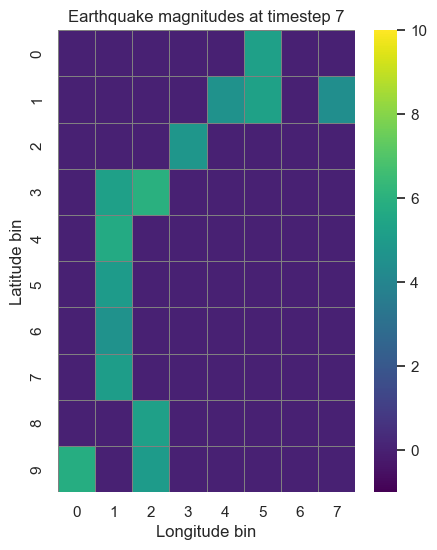

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Choose a timestep to plot (e.g. the first timestep)
timestep = 7
depth = 0
channel = 0

# Extract the data for the chosen timestep from the tensor
# tensor_convLSTM = tf.cast(tf.reduce_max(tensor_convLSTM, axis=2, keepdims=True) > 0, dtype=tf.int32)

data = tensor6D_convLSTM3D[0, timestep, channel, :, :, depth]

# Create a heatmap plot of the data using Seaborn
sns.set(rc={'figure.figsize':(4.8,6)})
sns.heatmap(data, cmap='viridis', vmin=-1, vmax=10, linewidths=0.5, linecolor='grey', annot=False)

# Set the plot title and axis labels
plt.title(f'Earthquake magnitudes at timestep {timestep}')
plt.xlabel('Longitude bin')
plt.ylabel('Latitude bin')

# Show the plot
plt.show()

### Splitting the data

In [31]:
from sklearn.model_selection import train_test_split

# split data in train en test set
tensor6D_convLSTM3D = tensor6D_convLSTM3D.reshape((tensor6D_convLSTM3D.shape[1], tensor6D_convLSTM3D.shape[2], tensor6D_convLSTM3D.shape[3], tensor6D_convLSTM3D.shape[4], tensor6D_convLSTM3D.shape[5]))

train, val_test = train_test_split(tensor6D_convLSTM3D, test_size=.4, shuffle=False, random_state=43)
val, test = train_test_split(val_test, test_size=.5, shuffle=False, random_state=43)

"""
train = train.reshape((1, train.shape[0], train.shape[1], train.shape[2], train.shape[3]))
val = val.reshape((1, val.shape[0], val.shape[1], val.shape[2], val.shape[3]))
test = test.reshape((1, test.shape[0], test.shape[1], test.shape[2], test.shape[3]))

# We'll define a helper function to shift the frames, where `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train)
x_val, y_val = create_shifted_frames(val)
x_test, y_test = create_shifted_frames(test)
"""

"\ntrain = train.reshape((1, train.shape[0], train.shape[1], train.shape[2], train.shape[3]))\nval = val.reshape((1, val.shape[0], val.shape[1], val.shape[2], val.shape[3]))\ntest = test.reshape((1, test.shape[0], test.shape[1], test.shape[2], test.shape[3]))\n\n# We'll define a helper function to shift the frames, where `x` is frames 0 to n - 1, and `y` is frames 1 to n.\ndef create_shifted_frames(data):\n    x = data[:, 0 : data.shape[1] - 1, :, :]\n    y = data[:, 1 : data.shape[1], :, :]\n    return x, y\n\n# Apply the processing function to the datasets.\nx_train, y_train = create_shifted_frames(train)\nx_val, y_val = create_shifted_frames(val)\nx_test, y_test = create_shifted_frames(test)\n"

### Generate dataset from timeseries V1

In [32]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
import tensorflow as tf

def dataset_generator(data, seq_length, cutoff):

  input_data = data # data[:-seq_length]
  targets = data[seq_length:]
  dataset = timeseries_dataset_from_array(input_data, (targets >= cutoff).astype(int), sequence_length=seq_length, sampling_rate=1, sequence_stride=1, shuffle=False, batch_size=len(data))
  """
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data[seq_length])  # Corresponding target: step 10
    """
  return dataset

# Set lookback timewindow
timewindow = 10

train_dataset = dataset_generator(train, timewindow, 4.5)
val_dataset = dataset_generator(val, timewindow, 4.5)
test_dataset = dataset_generator(test, timewindow, 4.5)

# Create train set
for batch in train_dataset:
    X_train, y_train = batch

y_train = tf.reshape(y_train, shape=[y_train.shape[0], 1, 1, y_train.shape[2], y_train.shape[3], y_train.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_train = tf.cast(tf.reduce_max(y_train, axis=5, keepdims=True) > 0, dtype=tf.int32)

# Create validation set
for batch in val_dataset:
    X_val, y_val = batch

y_val = tf.reshape(y_val, shape=[y_val.shape[0], 1, 1, y_val.shape[2], y_val.shape[3], y_val.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_val = tf.cast(tf.reduce_max(y_val, axis=5, keepdims=True) > 0, dtype=tf.int32)

# Create test set
for batch in test_dataset:
    X_test, y_test = batch

y_test = tf.reshape(y_test, shape=[y_test.shape[0], 1, 1, y_test.shape[2], y_test.shape[3], y_test.shape[4]])

# Collapse the depth dimension and converts all non-zero values to 1 and zero values to 0
y_test = tf.cast(tf.reduce_max(y_test, axis=5, keepdims=True) > 0, dtype=tf.int32)

### Modelconstruction of ConvLSTM3D

In [50]:
from keras import layers, regularizers
import keras
keras.backend.clear_session()

from tensorflow.keras import layers, models

# Construct the inputut layer with no definite frame size.
input = layers.Input(shape=(X_train.shape[1:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.BatchNormalization()(input)
x = layers.ConvLSTM3D(
    filters=16,
    kernel_size=(3, 3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format = "channels_first",
    # kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM3D(
    filters=1,
    kernel_size=(1, 1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
    data_format = "channels_first",
    kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
)(x)
x = layers.BatchNormalization()(x)

x = tf.reshape(x, (-1, 1, 1, x.shape[2], x.shape[3], x.shape[4]))
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(input, x)
print(model.summary())

model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall(), 'accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1, 10, 8, 5)  0         
                             ]                                   
                                                                 
 batch_normalization (BatchN  (None, 10, 1, 10, 8, 5)  20        
 ormalization)                                                   
                                                                 
 conv_lstm3d (ConvLSTM3D)    (None, 10, 16, 10, 8, 5)  29440     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 16, 10, 8, 5)  20       
 hNormalization)                                                 
                                                                 
 conv_lstm3d_1 (ConvLSTM3D)  (None, 1, 10, 8, 5)       72        
                                                             

### Modeltraining of ConvLSTM3D

In [51]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 32

# Fit the model to the training data.
model.fit(x=X_train,
          y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1)

Epoch 1/100
11/11 [==============================] - 6s 312ms/step - loss: 0.7034 - precision: 0.2199 - recall: 0.6330 - accuracy: 0.4973 - val_loss: 0.6844 - val_precision: 0.7870 - val_recall: 0.2910 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 2/100
11/11 [==============================] - 3s 311ms/step - loss: 0.6248 - precision: 0.4370 - recall: 0.6757 - accuracy: 0.7701 - val_loss: 0.6724 - val_precision: 0.7709 - val_recall: 0.4896 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 3/100
11/11 [==============================] - 3s 312ms/step - loss: 0.5512 - precision: 0.5548 - recall: 0.7943 - accuracy: 0.8378 - val_loss: 0.6630 - val_precision: 0.8231 - val_recall: 0.3742 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 4/100
11/11 [==============================] - 3s 314ms/step - loss: 0.4861 - precision: 0.5399 - recall: 0.8973 - accuracy: 0.8331 - val_loss: 0.6437 - val_precision: 0.8397 - val_recall: 0.3266 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 5/100
11/11 [=============================

In [52]:
y_pred = model.predict(X_test)

4/4 [==============================] - 1s 88ms/step


[Text(0, 0.5, 'M<6'), Text(0, 1.5, 'M>=6')]

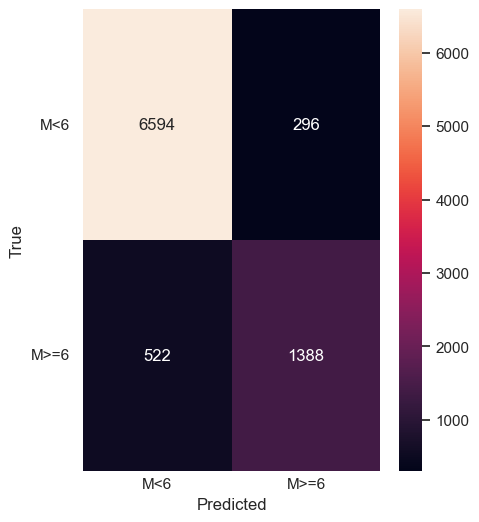

In [53]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
p = sns.heatmap(confusion_matrix(np.array(y_test).flatten(), y_pred.flatten() >= 0.5), annot=True, fmt='g')
p.set_xlabel("Predicted")
p.set_ylabel("True")
p.xaxis.set_ticklabels(['M<6', 'M>=6'], ha="center", va="center")
p.yaxis.set_ticklabels(['M<6', 'M>=6'], rotation=0, va="center")

In [54]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(np.array(y_test).flatten(), y_pred.flatten() >= 0.5)
print('F1 score: %f' % f1)

class_names = ['M<6', 'M>=6']

print(classification_report(np.array(y_test).flatten(), y_pred.flatten() >= 0.5, target_names=class_names))

Accuracy: 0.907045
Precision: 0.824228
Recall: 0.726702
F1 score: 0.772398
              precision    recall  f1-score   support

         M<6       0.93      0.96      0.94      6890
        M>=6       0.82      0.73      0.77      1910

    accuracy                           0.91      8800
   macro avg       0.88      0.84      0.86      8800
weighted avg       0.90      0.91      0.90      8800



## Hereafter is mainly redundant

In [ ]:
emdat = pd.read_excel("/Users/jurrienboogert/Downloads/emdat_public_2023_02_08_query_uid-jHccdA.xlsx", header=6)

In [ ]:
emdat[emdat['Disaster Type'] == 'Earthquake'][['Dis Mag Value']].max()

In [ ]:
tsv_file='/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/NOAA/earthquakes-2023-02-11_10-24-26_+0100.tsv'
NOAA=pd.read_table(tsv_file,sep='\t')


In [ ]:
NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag']

plt.hist(NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag'], bins=80)
plt.show()

NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag'].quantile(.025)

In [ ]:
NOAA.columns

In [ ]:
pd.to_datetime(NOAA[NOAA['Year'] > 2010][['year', 'month', 'day', 'hour', 'minute']])

In [ ]:
chunk1 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk1.csv", low_memory=False)
chunk2 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk2.csv", low_memory=False)
chunk3 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk3.csv", low_memory=False)
chunk4 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk4.csv", low_memory=False)
chunk5 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk5.csv", low_memory=False)
chunk6 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk6.csv", low_memory=False)

chunks = pd.concat([chunk2,chunk3,chunk4,chunk5,chunk6], ignore_index=True)
chunks['trace_start_time'] = pd.to_datetime(chunks['trace_start_time'])
chunks['source_origin_time'] = pd.to_datetime(chunks['source_origin_time'])
chunks = chunks.sort_values('source_origin_time')

In [ ]:
import matplotlib.pyplot as plt

subset = chunks[(chunks['source_longitude'] >= 19) & (chunks['source_longitude'] <= 30) & (chunks['source_latitude'] >= 34) & (chunks['source_latitude'] <= 44) & (chunks['source_origin_time'] <= '2015-6-25 03:14:47.900')]
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(subset.source_origin_time, subset.source_magnitude, s=1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

In [ ]:
plt.hist(subset.source_magnitude, bins=48)
plt.xlabel('magnitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by magnitude')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# create a histogram of the longitude values
plt.hist(subset.source_latitude, bins=360)
plt.xlabel('Longitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by Longitude')
plt.show()

# create a histogram of the latitude values
plt.hist(subset.source_longitude, bins=360)
plt.xlabel('Latitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by Latitude')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Load earthquake data
df = subset[chunks['source_magnitude'] >= 0].sort_values('source_magnitude')

# Extract latitude and longitude columns
latitudes = df['source_latitude']
longitudes = df['source_longitude']
magnitudes = df['source_magnitude']

# Set up map projection
fig, ax = plt.subplots(figsize=(16,6))
map = Basemap(projection='merc', lat_0=0, lon_0=0, resolution='l',
              llcrnrlon=19, llcrnrlat=33, urcrnrlon=30, urcrnrlat=43)

# Draw coastlines, countries, and states
#map.drawcoastlines(color='gray')
map.fillcontinents(color='lightgray', lake_color='white')
map.drawmapboundary(fill_color='white')

# Draw parallels and meridians
map.drawparallels(range(-90, 90, 1), linewidth=0.5, labels=[1, 0, 0, 0])
meridians = map.drawmeridians(range(-180, 180, 1), linewidth=0.5, labels=[0, 0, 0, 1])

for m in meridians:
    try:
        meridians[m][1][0].set_rotation(45)
    except:
        pass

# Convert latitude and longitude to map coordinates
x, y = map(longitudes, latitudes)

# Plot earthquake magnitudes as circles on the map
map.scatter(x, y, s=np.exp(magnitudes)/50, c=magnitudes, cmap='plasma', alpha=1)

# Add a colorbar
plt.colorbar(label='Magnitude')

# Add a title
plt.title('Earthquake Magnitudes')

# Show the plot
plt.show()


In [ ]:
from prophet import Prophet

# group the data by date and location to create the input data for Prophet
data = chunks.groupby([pd.Grouper(key='source_origin_time', freq='D'), 'source_latitude', 'source_longitude']).size().reset_index(name='count')

# rename columns for use with Prophet
data = data.rename(columns={'source_origin_time': 'ds', 'count': 'y'})

# create a Prophet model and fit the data
model = Prophet()
model.fit(data)

# create a future dataframe with predictions for the next 365 days
future = model.make_future_dataframe(periods=7)

# predict the number of earthquakes for the future dates
forecast = model.predict(future)

# plot the forecast
fig = model.plot(forecast, xlabel='Date', ylabel='Number of Earthquakes')


In [ ]:
plt.plot(chunks['source_origin_time'], chunks['source_magnitude'], 'ro', alpha=0.01)

In [ ]:
chunks[['source_magnitude', 'trace_start_time', 'source_origin_time', 'receiver_latitude', 'receiver_longitude', 'source_latitude', 'source_longitude']].tail(20)

In [ ]:
chunks[(chunks['source_origin_time'].dt.year == 2007) & (chunks['source_origin_time'].dt.month == 8) & (chunks['source_origin_time'].dt.day == 17) & (chunks['source_origin_time'].dt.hour == 0)]

In [ ]:
chunks[chunks['source_magnitude'] > 6].shape

In [ ]:
NOAA[(NOAA['Year'] > 1983) & (NOAA['Deaths'] > 0)].shape

In [ ]:
temp = pd.read_csv("/Users/jurrienboogert/Downloads/2023.csv", header=None, names=['ID', 'YEAR/MONTH/DAY', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME'])

In [ ]:
dly = pd.read_fwf('/Users/jurrienboogert/Downloads/ghcnd_gsn/ghcnd_gsn/USW00013782.dly')

In [ ]:
source = chunks.sample(1)[['source_latitude', 'source_longitude']]
source.iloc[0,0], source.iloc[0,1]

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

# Set time period
start = datetime(1984, 9, 7, 2)
end = datetime(1984, 9, 7, 3)

# Create Point for Vancouver, BC
Point.method = 'nearest'
Point.radius = 200000
Point.max_count = 6
Point.weight_dist = .6
receiver = Point(source.iloc[0,0], source.iloc[0,1])
# Get daily data for 2018
data = Hourly(receiver, start, end)


In [ ]:
chunks['source_origin_time'] = pd.to_datetime(chunks['source_origin_time'])
year = chunks['source_origin_time'].dt.year.fillna(0).astype('int')
month = chunks['source_origin_time'].dt.month.fillna(0).astype('int')
day = chunks['source_origin_time'].dt.day.fillna(0).astype('int')
hour = chunks['source_origin_time'].dt.hour.fillna(0).astype('int')

chunks.source_latitude
chunks.source_longitude

chunks.receiver_latitude
chunks.receiver_longitude
chunks.receiver_elevation_m

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

temp_source = []
rhum_source = []
pres_source = []
temp_receiver = []
rhum_receiver = []
pres_receiver = []
counter = 0

Point.method = 'nearest'
Point.radius = 2000000
Point.max_count = 10
Point.weight_dist = .6

for i in range(235426,len(chunks)):
    counter += 1
    start = datetime(year[i], month[i], day[i], hour[i])
    end = start

    source = Point(chunks.source_latitude[i], chunks.source_longitude[i])
    # Get daily data for 2018
    temp_source.append(Hourly(source, start, end).fetch()['temp'][0])
    rhum_source.append(Hourly(source, start, end).fetch()['rhum'][0])
    pres_source.append(Hourly(source, start, end).fetch()['pres'][0])

    if counter % 10 == 0:
        print(counter)


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Daily

temp_source = []
pres_source = []
temp_receiver = []
pres_receiver = []
counter = 0

Point.method = 'nearest'
Point.radius = 2000000
Point.max_count = 10
Point.weight_dist = .6

for i in range(235426,len(chunks)):
    counter += 1
    start = datetime(year[i], month[i], day[i])
    end = start

    source = Point(chunks.source_latitude[i], chunks.source_longitude[i])
    # Get daily data for 2018
    temp_source.append(Daily(source, start, end).fetch()['tavg'][0])
    pres_source.append(Daily(source, start, end).fetch()['pres'][0])

    Point.alt_range = chunks.receiver_elevation_m[i]
    Point.adapt_temp = True
    receiver = Point(chunks.receiver_latitude[i], chunks.receiver_longitude[i], chunks.receiver_elevation_m[i])
    # Get daily data for 2018
    temp_receiver.append(Daily(receiver, start, end).fetch()['tavg'][0])
    pres_receiver.append(Daily(receiver, start, end).fetch()['pres'][0])
    if counter % 10 == 0:
        print(counter)